# Importing Necessary Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

In [12]:
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

# Error level analysis

### List of images in dataset

In [13]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

au_list = get_imlist("./CASIA2/Au")
tp_list = get_imlist("./CASIA2/Tp")

In [14]:
au_list[0:10]

['./CASIA2/Au\\Au_ani_00001.jpg',
 './CASIA2/Au\\Au_ani_00002.jpg',
 './CASIA2/Au\\Au_ani_00003.jpg',
 './CASIA2/Au\\Au_ani_00004.jpg',
 './CASIA2/Au\\Au_ani_00005.jpg',
 './CASIA2/Au\\Au_ani_00006.jpg',
 './CASIA2/Au\\Au_ani_00007.jpg',
 './CASIA2/Au\\Au_ani_00008.jpg',
 './CASIA2/Au\\Au_ani_00009.jpg',
 './CASIA2/Au\\Au_ani_00010.jpg']

In [15]:
tp_list[0:10]

['./CASIA2/Tp\\Tp_D_CND_S_N_txt00028_txt00006_10848.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_B_nat10139_nat00059_11949.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_B_nat10139_nat00097_11948.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_N_ani00052_ani00054_11130.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_N_ani00057_ani00055_11149.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_N_art00052_arc00030_11853.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_N_cha00026_cha00028_11784.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_N_ind00091_ind00091_10647.jpg',
 './CASIA2/Tp\\Tp_D_CNN_M_N_ind00091_ind00091_10648.jpg']

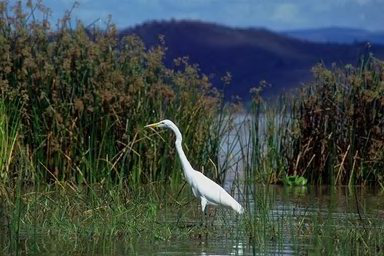

In [16]:
Image.open(au_list[1])

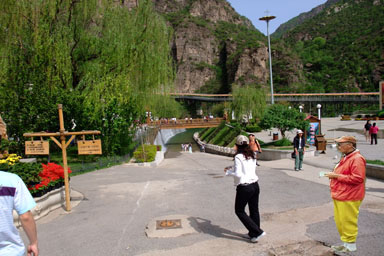

In [17]:
Image.open(tp_list[80])

### Error level analysis with example

In [18]:
def ErrorLevelAnalysis(path, quality):
    filename = path
    resaved_filename = './resaved/' + filename.split('.')[1].split('/CASIA2/')[1] + '.resaved.jpg'
    ELA_filename = './ELA/' + filename.split('.')[1].split('/CASIA2/')[1] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality,optimize=True)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

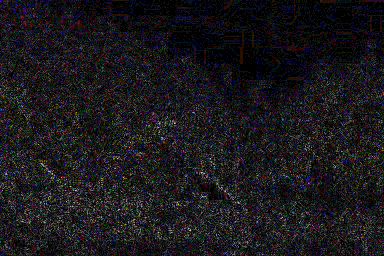

In [19]:
ErrorLevelAnalysis(au_list[1],90) #ELA on real image

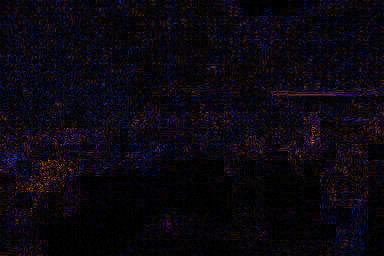

In [20]:
ErrorLevelAnalysis(tp_list[80],90) #ELA on fake image

In [21]:
'./resaved/' + tp_list[1].split('.')[1].split('/CASIA2/')[1] + '.resaved.jpg'

'./resaved/Tp\\Tp_D_CNN_M_B_nat00056_nat00099_11105.resaved.jpg'

In [22]:
'./ELA/' + au_list[1].split('.')[1].split('/CASIA2/')[1] + '.ela.png'

'./ELA/Au\\Au_ani_00002.ela.png'

# Preparation of Dataset

In [23]:
data_au = {'Path':au_list,'Value':[1]*len(au_list)}
au_df = pd.DataFrame.from_dict(data_au)

In [24]:
data_tp = {'Path':tp_list,'Value':[0]*len(tp_list)}
tp_df = pd.DataFrame.from_dict(data_tp)

In [25]:
au_df

,Path,Value
0,./CASIA2/Au\Au_ani_00001.jpg,1
1,./CASIA2/Au\Au_ani_00002.jpg,1
2,./CASIA2/Au\Au_ani_00003.jpg,1
3,./CASIA2/Au\Au_ani_00004.jpg,1
4,./CASIA2/Au\Au_ani_00005.jpg,1
...,...,...
7349,./CASIA2/Au\Au_txt_30025.jpg,1
7350,./CASIA2/Au\Au_txt_30026.jpg,1
7351,./CASIA2/Au\Au_txt_30027.jpg,1
7352,./CASIA2/Au\Au_txt_30028.jpg,1


In [26]:
tp_df

,Path,Value
0,./CASIA2/Tp\Tp_D_CND_S_N_txt00028_txt00006_108...,0
1,./CASIA2/Tp\Tp_D_CNN_M_B_nat00056_nat00099_111...,0
2,./CASIA2/Tp\Tp_D_CNN_M_B_nat10139_nat00059_119...,0
3,./CASIA2/Tp\Tp_D_CNN_M_B_nat10139_nat00097_119...,0
4,./CASIA2/Tp\Tp_D_CNN_M_N_ani00052_ani00054_111...,0
...,...,...
2059,./CASIA2/Tp\Tp_S_NRN_S_O_arc10129_arc10129_118...,0
2060,./CASIA2/Tp\Tp_S_NRN_S_O_cha00035_cha00067_117...,0
2061,./CASIA2/Tp\Tp_S_NRN_S_O_cha00077_cha00077_110...,0
2062,./CASIA2/Tp\Tp_S_NRN_S_O_cha10126_cha10126_121...,0


In [27]:
frames = [au_df,tp_df]
combined_df = pd.concat(frames)

In [28]:
combined_df.iloc[0,0]

'./CASIA2/Au\\Au_ani_00001.jpg'

# ELA on dataset and normalisation of data

In [29]:
X = []
Y = []
for index, row in au_df.iterrows():
    X.append(array(ErrorLevelAnalysis(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])

    
X1 = []
Y1 = []
for index, row in tp_df.iterrows():
    X1.append(array(ErrorLevelAnalysis(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y1.append(row[1])

In [30]:
X = np.array(X)
Y = to_categorical(Y, 2)
X1 = np.array(X1)
Y1 = to_categorical(Y1, 2)

In [31]:
X = X.reshape(-1, 128, 128, 3)
X1 = X1.reshape(-1, 128, 128, 3)

In [32]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=4)
X1_train, X1_val, Y1_train, Y1_val = train_test_split(X1, Y1, test_size = 0.2, random_state=5)

# CNN Model Training

In [33]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

model.summary()

Input:  (None, 128, 128, 3)
Output:  (None, 124, 124, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 120, 120, 32)
Input:  (None, 128, 128, 3)
Output:  (None, 60, 60, 32)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)   

In the deep learning model used 
1. the first layer CNN consists of convolutional layers with kernel size of 5x5 and the number of filters is 32. 
2. Second layer CNN consists of convolutional layers with kernel size of 5x5 and the number of filters is 32, and Max Pooling layer with size 2x2. 
3. After that, the MaxPooling layer added a dropout of 0.25 to prevent overfitting. 
4. Next layer is a fully connected layer with the number of neurons as many as 256 and the ReLU activation function.
5. After fully connected layer, we add a dropout of 0.5 to prevent overfitting.

In [34]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=2,verbose=1, mode='auto')

# Parameter explanation:
# monitor: which value should be monitored
# min_delta: Minimum change in the monitored quantity to qualify as an improvement
# patience: Number of epochs with no improvement after which training will be stopped
# mode: auto => in this mode based on the monitored value it stops once the value has not shown improvement
# verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [36]:
X_train = np.concatenate((X_train,X1_train))
Y_train = np.concatenate((Y_train,Y1_train))
X_val = np.concatenate((X_val,X1_val))
Y_val = np.concatenate((Y_val,Y1_val))

In [37]:
epochs = 30
batch_size = 100

In [38]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/30
76/76 [==============================] - 244s 3s/step - loss: 0.4419 - accuracy: 0.7982 - val_loss: 0.3705 - val_accuracy: 0.7914
Epoch 2/30
76/76 [==============================] - 246s 3s/step - loss: 0.2960 - accuracy: 0.8582 - val_loss: 0.2353 - val_accuracy: 0.9050
Epoch 3/30
76/76 [==============================] - 251s 3s/step - loss: 0.2341 - accuracy: 0.8971 - val_loss: 0.2184 - val_accuracy: 0.9108
Epoch 4/30
76/76 [==============================] - 254s 3s/step - loss: 0.2070 - accuracy: 0.9168 - val_loss: 0.2215 - val_accuracy: 0.9326
Epoch 5/30
76/76 [==============================] - 286s 4s/step - loss: 0.1917 - accuracy: 0.9234 - val_loss: 0.1680 - val_accuracy: 0.9363
Epoch 6/30
76/76 [==============================] - 272s 4s/step - loss: 0.1852 - accuracy: 0.9318 - val_loss: 0.1638 - val_accuracy: 0.9395
Epoch 7/30
76/76 [==============================] - 282s 4s/step - loss: 0.1722 - accuracy: 0.9360 - val_loss: 0.1666 - val_accuracy: 0.9395
Epoch 8/30
76

# Analysis of Model

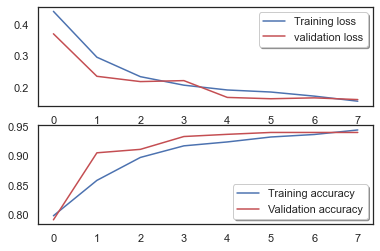

In [39]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


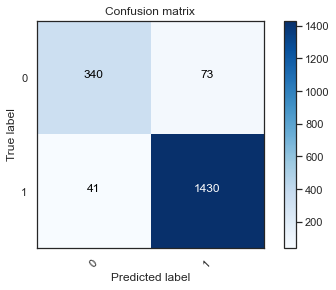

In [41]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Saving the Trained Model

In [128]:
'''import pickle
filename_model = 'FakeImage_CNNModel_resaved.sav'
pickle.dump(model, open(filename_model, 'wb'))'''

from keras.models import load_model
model.save('FakeImage_CNNModel_resaved.h5')

'''
model1 = load_model('FakeImage_CNNModel_resaved.h5')
y_pred = model1.predict(x_test)
'''

# Explainable AI (XAI) Implementation for above CNN Model

In [49]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

  0%|          | 0/1000 [00:00<?, ?it/s]

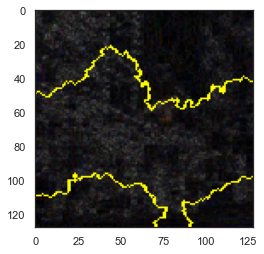

In [108]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(X_train[0], model.predict)
plt.imshow(X_train[0])
image, mask = explanation.get_image_and_mask(model.predict(X_train[0].reshape(-1,128,128,3)).argmax(axis=1)[0],positive_only=True, hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

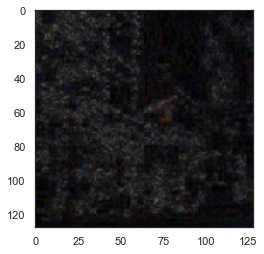

In [109]:
plt.imshow(X_train[0])

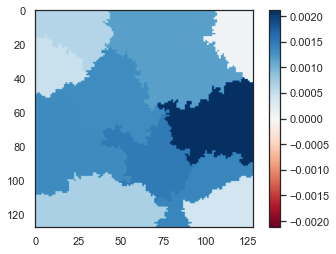

In [75]:
ind =  model.predict(X_train[0].reshape(-1,128,128,3)).argmax(axis=1)[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

  0%|          | 0/1000 [00:00<?, ?it/s]

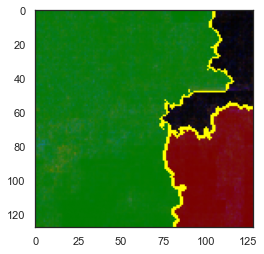

In [137]:
temp = []
temp.append(array(ErrorLevelAnalysis(tp_list[80], 90).resize((128, 128))).flatten() / 255.0)
temp = np.array(temp)
temp = temp.reshape(-1, 128, 128, 3)
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(temp.reshape(128,128,3), model.predict)
plt.imshow(temp.reshape(128,128,3))
image, mask = explanation.get_image_and_mask(model.predict(temp.reshape(-1,128,128,3)).argmax(axis=1)[0],positive_only=False, hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

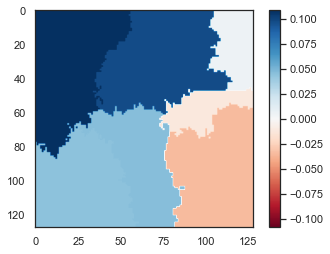

In [136]:
ind =  model.predict(temp.reshape(-1,128,128,3)).argmax(axis=1)[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [133]:
model.predict(temp.reshape(-1,128,128,3))

array([[0.80599135, 0.1940087 ]], dtype=float32)

In [134]:
print(ind)

0
